In [124]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly as px

In [125]:
pd.set_option('display.max_columns', None)

In [126]:
df = pd.read_csv('treated_v1.csv').drop_duplicates()

In [127]:
df.sample()

,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,AGE,FACING,FURNISH,amenity_luxury,FLOOR_NUM,LATITUDE,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
2295,S70353834,flat,Gora1,Kolkata South,Behala,1.0,1.0,400,3375.0,0.14,Relatively New Property,2,Fully furnished,NaN,0,22.536025,88.35469,gora1,3.0,"['2 Metro Stations', '1 Shopping', '1 Religiou...",A 1 bedroom of 400 sqft resale flat available ...


In [128]:
df.shape

(5150, 21)

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML

def column_details(data, column, histplot=True, kde=True, violin_plot=False, boxplot=True, value_counts=True, bar_plot=True, outlier_df=True, plots_per_row=2, outlier_df_columns=None, all_row=False, all_column=False, figsize=(12, 6), sort=(True, None, 'descending'), export=None):
    # Set display options based on the all_row and all_column parameters
    pd.set_option('display.max_rows', None if all_row else 10)
    pd.set_option('display.max_columns', None if all_column else 10)
    
    # Check if sorting should be performed
    if sort:
        if isinstance(sort, tuple) and sort[0]:
            sort_column = sort[1] if sort[1] else column
            sort_order = sort[2] == 'ascending'
            data = data.sort_values(by=sort_column, ascending=sort_order)
        elif sort is True:
            data = data.sort_values(by=column, ascending=True)
    
    # Check if the column exists in the DataFrame
    if column not in data.columns:
        raise ValueError(f"The column '{column}' does not exist in the DataFrame.")
    
    # Identify data type
    dtype = data[column].dtype

    # Descriptive statistics and general details
    missing_values = data[column].isna().sum()
    left_output = "<h3>Data Descriptive Statistics:</h3>"
    left_output += "<pre>{}</pre>".format(data[column].describe(include='all').to_string())
    
    if value_counts:
        left_output += "<h3>Value Counts:</h3>"
        left_output += "<pre>{}</pre>".format(data[column].value_counts().to_string())

    # Outliers analysis for numeric dtype
    right_output = ""
    num_of_outliers = 0  # Initialize number of outliers
    outlier_df_columns = outlier_df_columns or [column]  # Default to current column if not specified

    # Initialize plots list
    plots = []

    # If dtype is numeric, calculate skewness, kurtosis, and outliers
    if pd.api.types.is_numeric_dtype(dtype):
        skewness = data[column].skew()
        kurtosis = data[column].kurt()

        # Skewness and kurtosis interpretation
        skew_note = "Data is positively skewed." if skewness > 0 else "Data is negatively skewed." if skewness < 0 else "Data is symmetric."
        kurt_note = "Data has a sharper peak than a normal distribution (leptokurtic)." if kurtosis > 3 else "Data has a flatter peak than a normal distribution (platykurtic)." if kurtosis < 3 else "Data has a normal peak (mesokurtic)."

        # Outliers detection
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        num_of_outliers = outliers.shape[0]
        outliers_stats = outliers[column].describe()

        outliers_skewness = outliers[column].skew()
        outliers_kurtosis = outliers[column].kurt()

        outliers_skew_note = "Outliers data is positively skewed." if outliers_skewness > 0 else "Outliers data is negatively skewed." if outliers_skewness < 0 else "Outliers data is symmetric."
        outliers_kurt_note = "Outliers data has a sharper peak than a normal distribution (leptokurtic)." if outliers_kurtosis > 3 else "Outliers data has a flatter peak than a normal distribution (platykurtic)." if outliers_kurtosis < 3 else "Outliers data has a normal peak (mesokurtic)."

        # Correct analysis notes
        outliers_analysis_note = f"<b>Analysis Note:</b><br>{outliers_skew_note}<br>{outliers_kurt_note}<br>"

        right_output = "<h3>Outliers Descriptive Statistics:</h3>"
        right_output += "<pre>{}</pre>".format(outliers_stats.to_string())

        if value_counts:
            right_output += "<h3>Outliers Value Counts:</h3>"
            right_output += "<pre>{}</pre>".format(outliers[column].value_counts().to_string())

        right_output += "<h3>Outliers Skewness & Kurtosis:</h3>"
        right_output += "<pre>Skewness : {:.6f}<br>Kurtosis : {:.6f}</pre>".format(outliers_skewness, outliers_kurtosis)
        right_output += f"<p style='margin-top: 20px;'>{outliers_analysis_note}</p>"

        # Correct placement for overall data
        analysis_note = f"<b>Analysis Note:</b><br>Missing values : {missing_values}<br>Number of outliers : {num_of_outliers}<br>Data type : {dtype}<br>{skew_note}<br>{kurt_note}"
        left_output += f"<h3>Skewness & Kurtosis:</h3><pre>Skewness : {skewness:.6f}<br>Kurtosis : {kurtosis:.6f}</pre>"
    
    # Handling object (categorical) dtype
    elif pd.api.types.is_object_dtype(dtype):
        analysis_note = f"<b>Analysis Note:</b><br>Missing values : {missing_values}<br>Data type : {dtype}"

        # Additional analysis for categorical data
        mode_value = data[column].mode().values
        cardinality = data[column].nunique()

        analysis_note += f"<br>Mode : {', '.join(map(str, mode_value))}<br>Cardinality (Number of unique categories) : {cardinality}"

        if cardinality < 5:
            analysis_note += "<br>Low cardinality detected (fewer than 5 unique categories)."
        elif cardinality > 15:
            analysis_note += "<br>High cardinality detected (more than 15 unique categories)."

    else:
        analysis_note = f"<b>Analysis Note:</b><br>Missing values : {missing_values}<br>Data type : {dtype}"

    left_output += f"<p style='margin-top: 20px;'>{analysis_note}</p>"

    # Display text side by side using HTML and CSS for layout
    display(HTML(f"""
    <div style='display: flex;'>
        <div style='flex: 50%; padding-right: 20px;'>{left_output}</div>
        <div style='flex: 50%;'>{right_output}</div>
    </div>
    """))

    # Determine the number of plots to be created
    if pd.api.types.is_numeric_dtype(dtype):
        if histplot:
            plots.append(('Histogram (Full Data)', sns.histplot, {'data': data[column], 'kde': kde}))
            plots.append(('Histogram (Outliers)', sns.histplot, {'data': outliers[column], 'kde': kde, 'color': 'orange'}))
        if kde and not histplot:
            plots.append(('KDE Plot (Full Data)', sns.kdeplot, {'data': data[column], 'fill': True}))
            plots.append(('KDE Plot (Outliers)', sns.kdeplot, {'data': outliers[column], 'fill': True, 'color': 'orange'}))
        if violin_plot:
            plots.append(('Violin Plot (Full Data)', sns.violinplot, {'x': data[column]}))
            plots.append(('Violin Plot (Outliers)', sns.violinplot, {'x': outliers[column], 'color': 'orange'}))
        if boxplot:
            plots.append(('Box Plot (Full Data)', sns.boxplot, {'x': data[column]}))
            plots.append(('Box Plot (Outliers)', sns.boxplot, {'x': outliers[column], 'color': 'orange'}))
    if bar_plot and pd.api.types.is_object_dtype(dtype):
        plots.append(('Bar Plot (Value Counts - Full Data)', data[column].value_counts().plot, {'kind': 'bar'}))

    # Number of plots
    num_plots = len(plots)

    # Handle plotting only if there are plots to display
    if num_plots > 0:
        figsize = (figsize[0], max(num_plots // plots_per_row, 1) * 4)  # Adjust size for two-column plots
        num_rows = (num_plots + plots_per_row - 1) // plots_per_row
        fig, axes = plt.subplots(num_rows, plots_per_row, figsize=figsize)
        
        # Ensure axes is always a list or numpy array
        if num_rows == 1 and plots_per_row == 1:
            axes = [axes]
        elif num_rows == 1 or plots_per_row == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()

        for i, (title, plot_func, kwargs) in enumerate(plots):
            ax = axes[i] if i < len(axes) else None
            if ax:
                plot_func(ax=ax, **kwargs)
                ax.set_title(title)
                ax.set_xlabel(column)
        
        # Hide unused axes
        for i in range(len(plots), len(axes)):
            axes[i].axis('off')
        
        # Adjust layout
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.show()

    # Additional Feature: Showing outliers for the analyzed column
    if outlier_df and num_of_outliers > 0:
        if len(outlier_df_columns) > 1:
            outlier_df_result = outliers[outlier_df_columns]
        else:
            outlier_df_result = outliers
        print(f"\nOutlier DataFrame for '{column}':")
        display(outlier_df_result)

        # Save to specified variable if 'export' is provided
        if export:
            globals()[export] = outlier_df_result

    # Reset display options to default
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')



<Axes: ylabel='BEDROOM_NUM'>

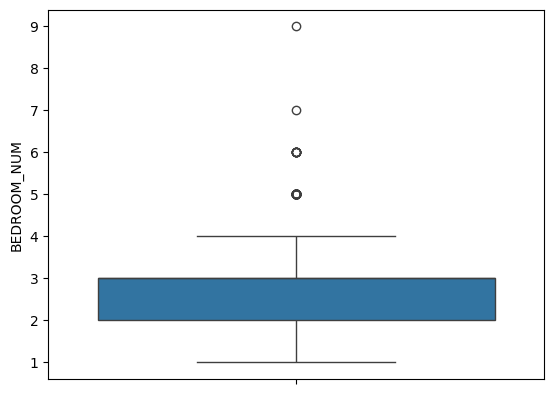

In [130]:
sns.boxplot(df['BEDROOM_NUM'])

In [131]:
df[df['BEDROOM_NUM']>5]

,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,AGE,FACING,FURNISH,amenity_luxury,FLOOR_NUM,LATITUDE,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
697,X70089504,flat,City High,Kolkata South,Prince Anwar Shah Rd,6.0,4.0,4342,11515.0,5.00,Moderately Old,7,Semi-furnished,441.0,12,22.502633,88.366453,City High,16.0,"['2 Religious Places', '16 Hospitals', '1 Attr...",This property located in the very pause and ex...
1092,K71276956,flat,Maya Kutir Sodepur,Kolkata North,Panihati,7.0,3.0,2310,4761.0,1.10,New Property,3,Luxury furnished,253.0,1,22.696664,88.371270,Maya Kutir Sodepur,1.0,"['1 Religious Place', '16 Hospitals', '1 Attra...",This 7bhk house is just 4 yrs old .. It's loca...
1263,F71262812,flat,Rsh Signature,Kolkata South,Tollygunge,6.0,4.0,6694,12249.0,8.20,New Property,7,Fully furnished,338.0,21,22.500000,88.350000,RSH Signature,30.0,"['2 Metro Stations', '2 Religious Places', '1 ...","Best location , golf club road.. Good communic..."
2101,V71110692,flat,Ps Navyom,Kolkata South,New Alipore,6.0,0.0,3257,18114.0,5.90,Old Property,3,Fully furnished,495.0,5,22.509854,88.331069,PS Navyom,11.0,"['2 Metro Stations', '4 Shoppings', '1 Connect...",A 6 bhk duplex in the premium tower at the 4th...
2123,F71094532,flat,New Alipore,Kolkata South,New Alipore,9.0,4.0,2500,3520.0,0.88,Moderately Old,2,Fully furnished,23.0,2,22.501180,88.333934,New Alipore,2.0,"['2 Metro Stations', '1 Shopping', '4 Religiou...","This beautiful 9 bhk flat in new alipore, kolk..."
2920,M70459126,flat,Atree,Kolkata East,Action Area 2B,6.0,2.0,2500,4600.0,1.15,Relatively New Property,2,Fully furnished,21.0,4,22.427980,88.417960,Atree,4.0,['3 Hospitals'],Check out this 6 bhk apartment for sale in atr...
3893,D71124348,flat,S.K Real Estate,Kolkata South,New Alipore,6.0,2.0,3450,10579.0,3.65,Old Property,7,Fully furnished,226.0,2,22.514358,88.325146,S.K Real Estate,4.0,"['1 Shopping', '5 Religious Places', '5 ATMs',...",Located in the popular residential address of ...
4025,O70726216,flat,Ps Navyom,Kolkata South,New Alipore,6.0,4.0,5350,13420.0,7.18,Relatively New Property,0,Fully furnished,80.0,2,22.509854,88.331069,PS Navyom,11.0,"['2 Metro Stations', '4 Shoppings', '1 Connect...","A getaway within the gates. 40,000 sqft. Of se..."
4547,X68257476,flat,NaN,Kolkata East,New Town,6.0,2.0,2640,6060.0,1.60,Moderately Old,3,Semi-furnished,441.0,4,22.577970,88.450584,on request,4.0,"['1 Metro Station', '4 ATMs', '5 Hospitals', '...","A 6 bhk flat in new town, kolkata east is avai..."
4830,A67641986,flat,Propterior,Kolkata South,Ballygunge Circular Road,6.0,4.0,4700,16510.0,7.76,Relatively New Property,7,Fully furnished,617.0,4,22.536398,88.357662,Propterior,12.0,"['1 Shopping', '1 Religious Place', '3 ATMs', ...","Situated in ballygunge circular road, kolkata ..."


In [132]:
df['BEDROOM_NUM'].value_counts()

BEDROOM_NUM
3.0    2305
2.0    2111
4.0     464
1.0     212
5.0      48
6.0       8
7.0       1
9.0       1
Name: count, dtype: int64

<Axes: xlabel='BEDROOM_NUM'>

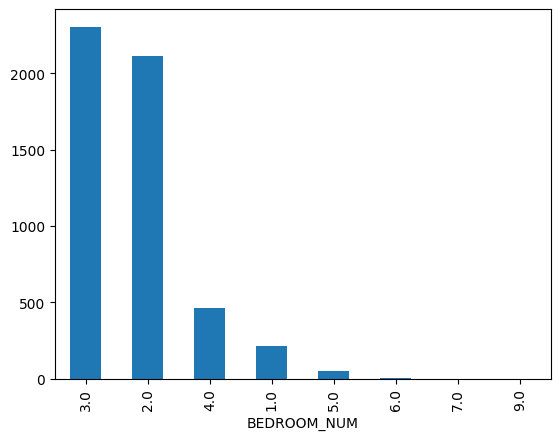

In [133]:
df['BEDROOM_NUM'].value_counts().plot(kind='bar')

In [134]:
df[df['BEDROOM_NUM']>6]

,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,AGE,FACING,FURNISH,amenity_luxury,FLOOR_NUM,LATITUDE,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
1092,K71276956,flat,Maya Kutir Sodepur,Kolkata North,Panihati,7.0,3.0,2310,4761.0,1.10,New Property,3,Luxury furnished,253.0,1,22.696664,88.371270,Maya Kutir Sodepur,1.0,"['1 Religious Place', '16 Hospitals', '1 Attra...",This 7bhk house is just 4 yrs old .. It's loca...
2123,F71094532,flat,New Alipore,Kolkata South,New Alipore,9.0,4.0,2500,3520.0,0.88,Moderately Old,2,Fully furnished,23.0,2,22.501180,88.333934,New Alipore,2.0,"['2 Metro Stations', '1 Shopping', '4 Religiou...","This beautiful 9 bhk flat in new alipore, kolk..."


In [135]:
df = df[df['BEDROOM_NUM']<=6]

<Axes: xlabel='BEDROOM_NUM'>

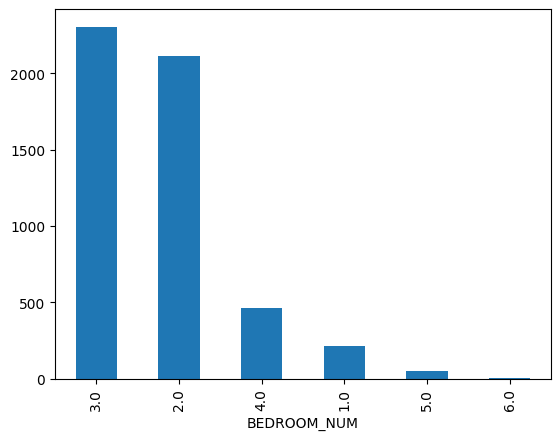

In [136]:
df['BEDROOM_NUM'].value_counts().plot(kind='bar')

In [137]:
df.shape

(5148, 21)

# PRICE:

C:\Users\dipan\AppData\Local\Temp\ipykernel_1360\2522233195.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['PRICE'])


<Axes: xlabel='PRICE', ylabel='Density'>

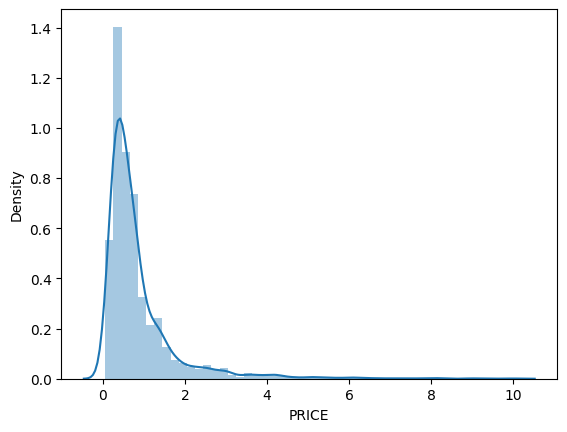

In [138]:
sns.distplot(df['PRICE'])

In [139]:
df['PRICE'].describe()

count    5148.000000
mean        0.867953
std         0.960927
min         0.060000
25%         0.350000
50%         0.580000
75%         0.950000
max        10.000000
Name: PRICE, dtype: float64

In [140]:
skewness = df['PRICE'].skew()
kurtosis = df['PRICE'].kurt()
skewness, kurtosis

(3.7240072831985076, 19.404608839881302)

<Axes: xlabel='PRICE'>

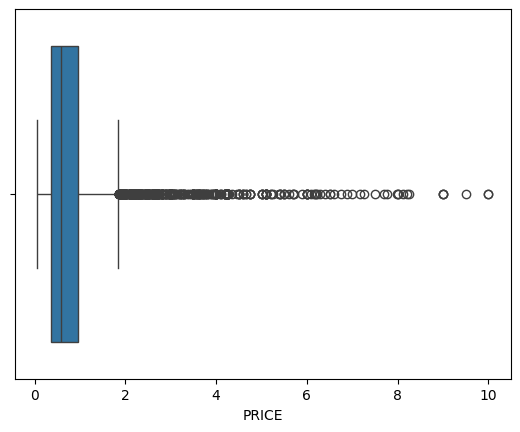

In [141]:
sns.boxplot(x = df['PRICE'])

# Making some usefull functions:

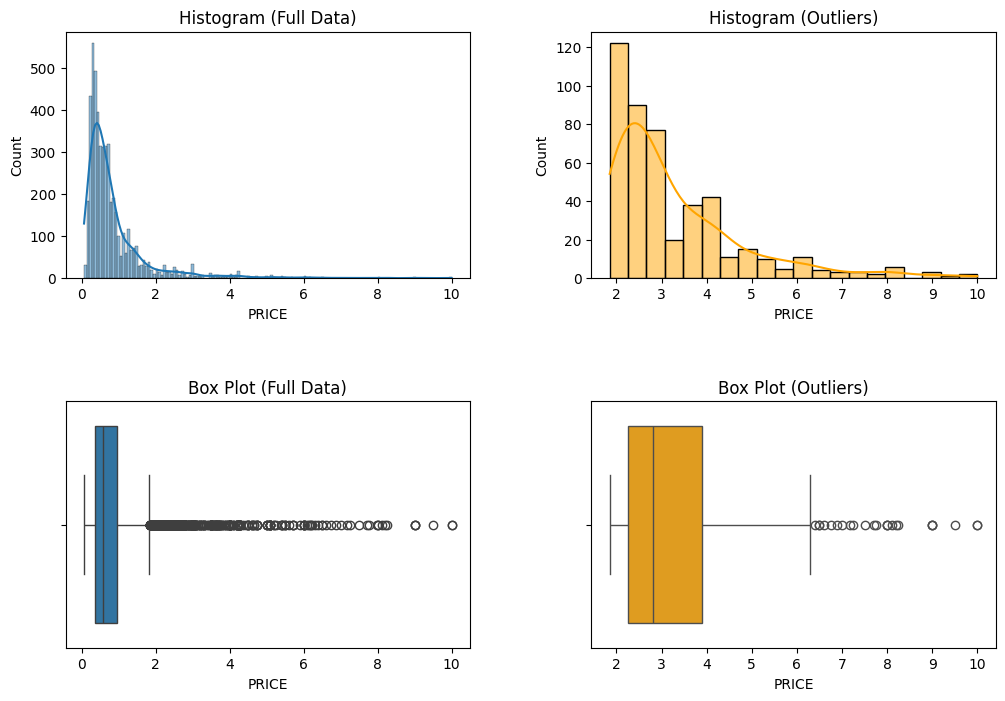


Outlier DataFrame for 'PRICE':


,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,...,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
5056,H67670344,flat,Ps Astoria,Kolkata Central,Rowdon Street,...,88.358333,PS Astoria,14.0,"['1 Religious Place', '1 ATM', '17 Hospitals',...","4 bhk 4 toilets for sale in ps astoria ,rowdon..."
4951,L70927584,flat,Ps Anassa,Kolkata East,Em Bypass,...,88.399999,PS Anassa,35.0,"['1 Metro Station', '1 Connectivity', '1 Educa...",5 bhk spacoius apartment at 12th floor with tr...
3933,U69590414,flat,Ps The Reserve,Kolkata South,Ballygunge,...,88.357794,PS The Reserve,33.0,"['1 Religious Place', '2 ATMs', '16 Hospitals'...",The reserve is one of the acclaimed premium lu...
3916,J70753452,flat,Keventer Crosswinds,Kolkata South,Alipore,...,88.335128,Keventer Crosswinds,10.0,"['2 Metro Stations', '2 Religious Places', '3 ...","A beuatiful furnished property, for further de..."
3899,P71029070,flat,Keventer Crosswinds,Kolkata South,Alipore,...,88.335128,Keventer Crosswinds,10.0,"['2 Metro Stations', '2 Religious Places', '3 ...",Crosswinds at alipore is like a blank slate. W...
...,...,...,...,...,...,...,...,...,...,...,...
2756,O70399494,flat,Tata Eden Court,Kolkata East,Action Area 2,...,88.493805,Tata Eden Court,29.0,"['1 Religious Place', '2 ATMs', '4 Hospitals',...",The 3bhk hig flat is in one of the prominent s...
4199,H70446660,flat,South City,Kolkata South,Prince Anwar Shah Rd,...,88.360697,South City,35.0,"['2 Shoppings', '5 Educations', '1 ATM', '1 Ho...",This lovely 3 bhk apartment/flat in prince anw...
3829,Y71362354,flat,S.K Real Estate,Kolkata South,New Alipore,...,88.325146,S.K Real Estate,4.0,"['1 Shopping', '5 Religious Places', '5 ATMs',...","Situated in new alipore, kolkata south, s.K re..."
2318,P71236918,flat,Asha Apartment,Kolkata South,Tollygunge,...,88.350000,Asha Apartment,16.0,"['2 Metro Stations', '2 Religious Places', '1 ...",2600 super built 2150 sqft carpet spacious 4 b...


In [142]:
column_details(df, column='PRICE',value_counts=False,bar_plot=False)

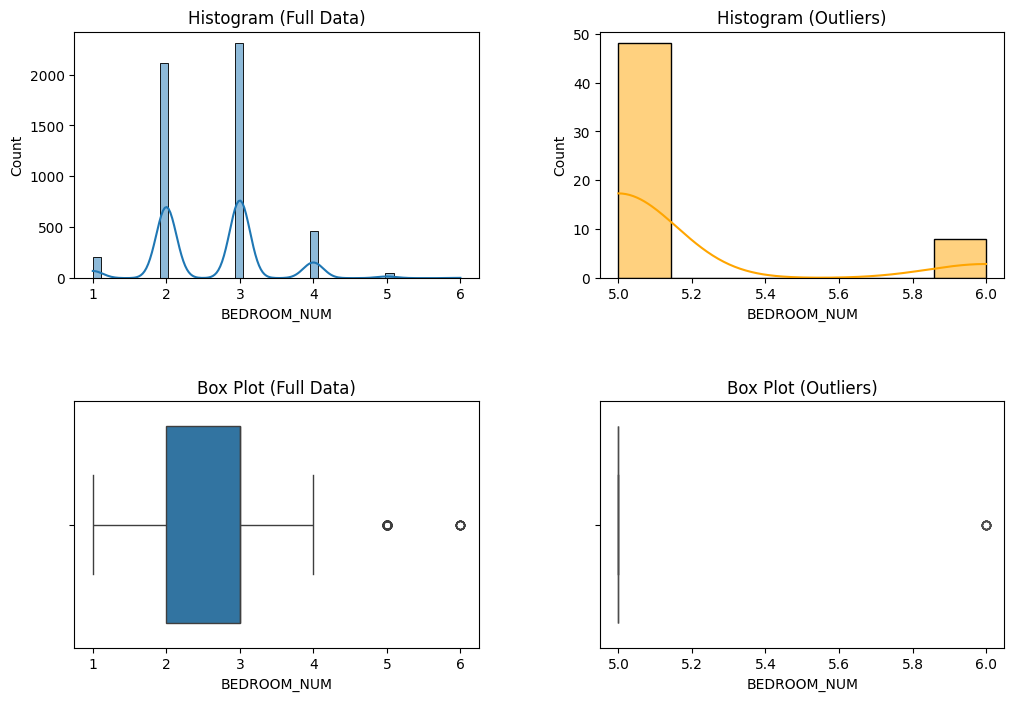


Outlier DataFrame for 'BEDROOM_NUM':


,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,...,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
1263,F71262812,flat,Rsh Signature,Kolkata South,Tollygunge,...,88.350000,RSH Signature,30.0,"['2 Metro Stations', '2 Religious Places', '1 ...","Best location , golf club road.. Good communic..."
2101,V71110692,flat,Ps Navyom,Kolkata South,New Alipore,...,88.331069,PS Navyom,11.0,"['2 Metro Stations', '4 Shoppings', '1 Connect...",A 6 bhk duplex in the premium tower at the 4th...
4830,A67641986,flat,Propterior,Kolkata South,Ballygunge Circular Road,...,88.357662,Propterior,12.0,"['1 Shopping', '1 Religious Place', '3 ATMs', ...","Situated in ballygunge circular road, kolkata ..."
4547,X68257476,flat,NaN,Kolkata East,New Town,...,88.450584,on request,4.0,"['1 Metro Station', '4 ATMs', '5 Hospitals', '...","A 6 bhk flat in new town, kolkata east is avai..."
3893,D71124348,flat,S.K Real Estate,Kolkata South,New Alipore,...,88.325146,S.K Real Estate,4.0,"['1 Shopping', '5 Religious Places', '5 ATMs',...",Located in the popular residential address of ...
...,...,...,...,...,...,...,...,...,...,...,...
763,I71394786,flat,Rajwada Royal Gardens,Kolkata South,Narendrapur,...,88.401162,Rajwada Royal Gardens,20.0,"['1 Metro Station', '2 Shoppings', '2 Educatio...","Book your 5 BHK flat in Narendrapur, Kolkata S..."
5003,L53259672,flat,Z Projects,Kolkata South,Em Bypass,...,88.354690,Z Projects,38.0,"['2 Metro Stations', '1 Shopping', '1 Religiou...","A beautiful 5 bhk apartment in em bypass, kolk..."
274,L71261538,flat,Swarnamani,Kolkata North,Em Bypass,...,88.399053,Swarnamani,32.0,"['1 Hospital', '1 Airport', '1 Bus Stop', '1 R...",Raw flat on 23rd floor with 2 car parkings. No...
854,E70965944,flat,Tata Avenida,Kolkata East,New Town,...,88.496134,Tata Avenida,29.0,"['2 Shoppings', '5 Educations', '2 Hospitals',...",Make Tata Avenida your next home. Book your 5 ...


In [143]:
column_details(df,'BEDROOM_NUM')

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5148 entries, 0 to 5149
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PROP_ID                     5148 non-null   object 
 1   PROPERTY_TYPE               5148 non-null   object 
 2   SOCIETY_NAME                4495 non-null   object 
 3   CITY                        5148 non-null   object 
 4   location                    5148 non-null   object 
 5   BEDROOM_NUM                 5148 non-null   float64
 6   BALCONY_NUM                 4676 non-null   float64
 7   AREA                        5148 non-null   int64  
 8   Price_per_sqft              5148 non-null   float64
 9   PRICE                       5148 non-null   float64
 10  AGE                         5148 non-null   object 
 11  FACING                      5148 non-null   int64  
 12  FURNISH                     5148 non-null   object 
 13  amenity_luxury              4486 non-n

In [145]:
column_details(df,'SOCIETY_NAME',value_counts = False,bar_plot=False)

# Price_per_sqft:

In [146]:
df['Price_per_sqft'].isnull().sum()

0

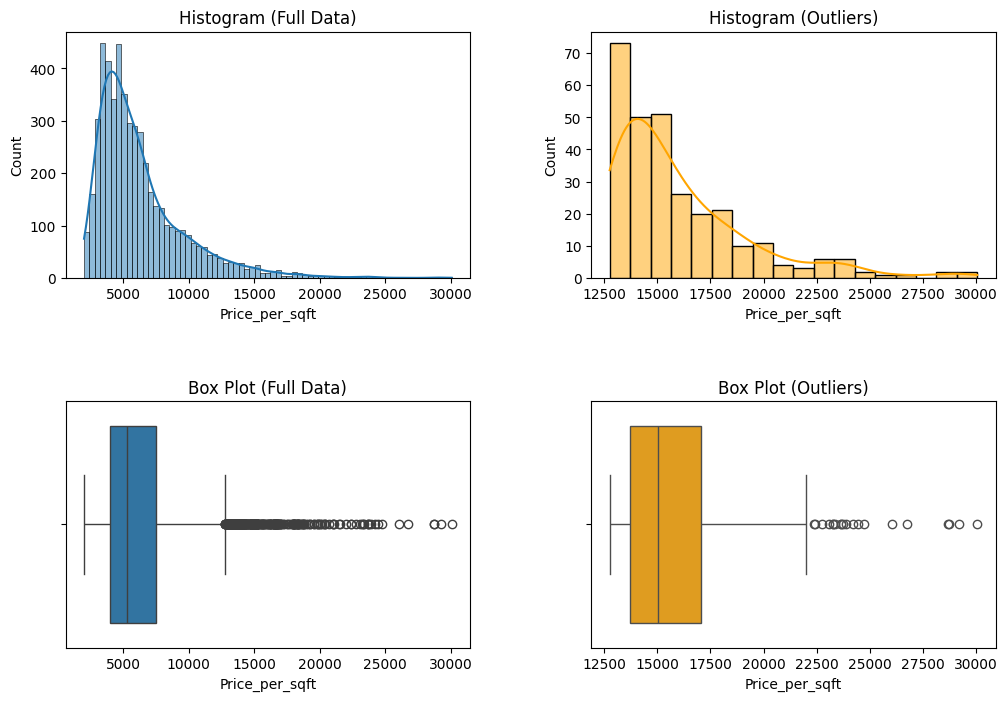


Outlier DataFrame for 'Price_per_sqft':


,Price_per_sqft,PRICE,BEDROOM_NUM,AREA,AGE,FURNISH,TOTAL_FLOOR
3933,30063.0,9.50,4.0,3160,Old Property,Fully furnished,33.0
5000,29222.0,5.00,3.0,1711,Old Property,Fully furnished,42.0
5001,28710.0,7.99,4.0,2783,Old Property,Fully furnished,42.0
4982,28683.0,5.10,4.0,2822,Old Property,Fully furnished,34.0
5002,26763.0,3.30,3.0,1233,Old Property,Fully furnished,42.0
2114,26060.0,2.95,3.0,2623,Old Property,Fully furnished,23.0
3832,24734.0,7.70,4.0,3113,Old Property,Unfurnished,32.0
2788,24461.0,2.50,3.0,1022,Old Property,Fully furnished,18.0
1293,24193.0,2.70,3.0,1891,Old Property,Luxury furnished,23.0
4026,23880.0,8.00,4.0,3350,Old Property,Fully furnished,16.0


In [147]:
column_details(df,'Price_per_sqft',value_counts=False,bar_plot=False,all_row=True,outlier_df_columns=['Price_per_sqft','PRICE','BEDROOM_NUM','AREA','AGE','FURNISH','TOTAL_FLOOR'],export='new_df')

<Axes: xlabel='TOTAL_FLOOR', ylabel='Price_per_sqft'>

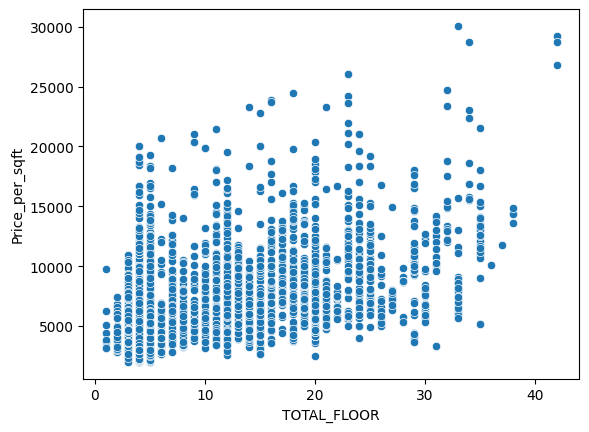

In [148]:
sns.scatterplot(df, x = 'TOTAL_FLOOR', y = 'Price_per_sqft')

<Axes: xlabel='FLOOR_NUM', ylabel='Price_per_sqft'>

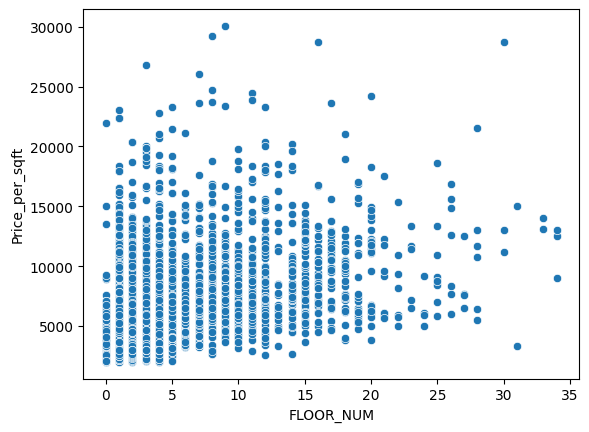

In [149]:
 sns.scatterplot(df, x = 'FLOOR_NUM', y = 'Price_per_sqft')

<Axes: xlabel='PRICE', ylabel='Price_per_sqft'>

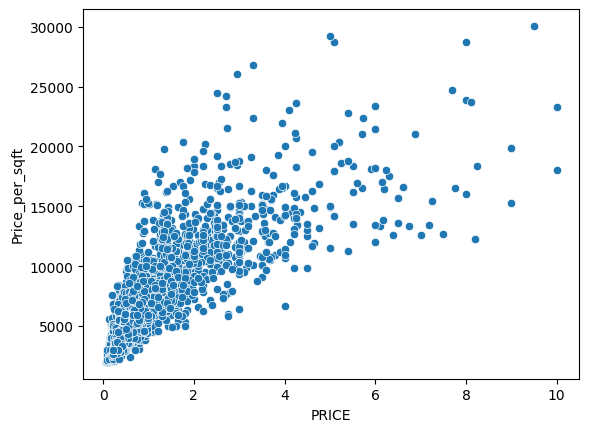

In [150]:
 sns.scatterplot(df, x = 'PRICE', y = 'Price_per_sqft')

# AREA:

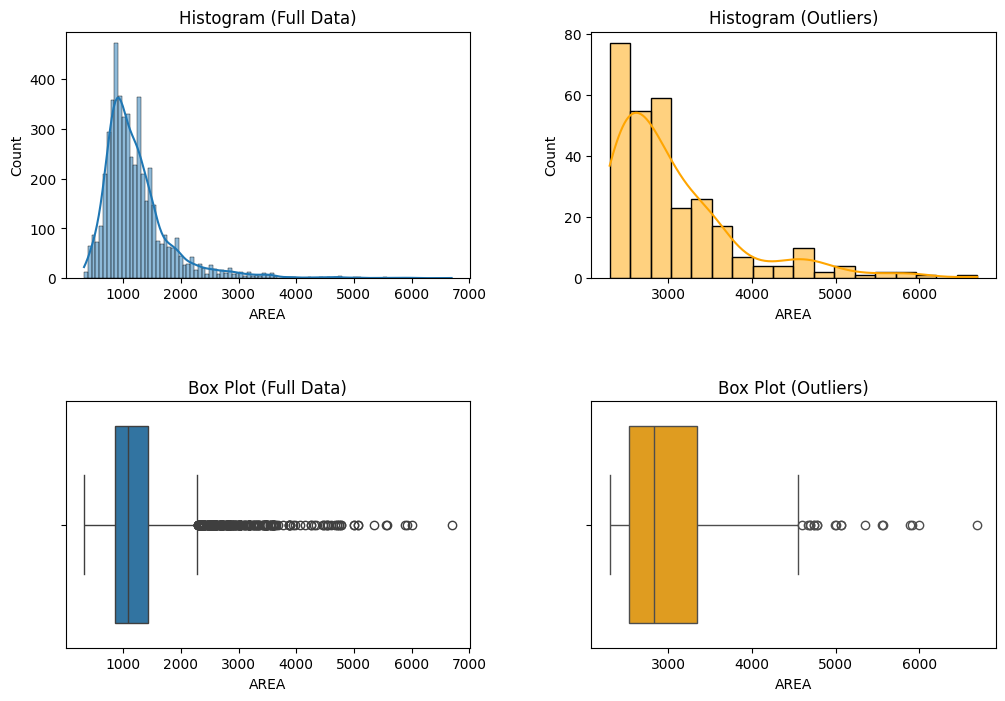


Outlier DataFrame for 'AREA':


,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,AGE,FACING,FURNISH,amenity_luxury,FLOOR_NUM,LATITUDE,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
1263,F71262812,flat,Rsh Signature,Kolkata South,Tollygunge,6.0,4.0,6694,12249.0,8.20,New Property,7,Fully furnished,338.0,21,22.500000,88.350000,RSH Signature,30.0,"['2 Metro Stations', '2 Religious Places', '1 ...","Best location , golf club road.. Good communic..."
4997,L71059668,flat,Ambuja Ujjwala The Condoville,Kolkata East,New Town,4.0,2.0,6000,6666.0,4.00,New Property,7,Fully furnished,314.0,11,22.600691,88.469454,Ambuja Ujjwala The Condoville,13.0,"['2 Religious Places', '3 ATMs', '5 Hospitals'...",Located in the popular residential address of ...
1875,B71216192,flat,Rsh Signature,Kolkata South,Tollygunge,4.0,3.0,5915,12679.0,7.50,Relatively New Property,7,Fully furnished,527.0,15,22.497815,88.350904,RSH Signature,30.0,"['2 Metro Stations', '3 Religious Places', '3 ...",Rsh signature brings you elegant homes in kolk...
3918,Q63106988,flat,Aqua Beaumont,Kolkata South,Em Bypass,5.0,2.0,5889,15282.0,9.00,Relatively New Property,0,Fully furnished,99.0,12,22.519222,88.399659,Aqua Beaumont,12.0,"['15 Religious Places', '3 ATMs', '12 Hospital...",This beautiful 5 bhk apartment/flat in em bypa...
4998,Q63312088,flat,Prasad Rare Earth,Kolkata North,Narkeldanga,4.0,3.0,5572,12562.0,7.00,Old Property,2,Fully furnished,579.0,26,22.573977,88.398249,Prasad Rare Earth,35.0,"['1 Metro Station', '1 Education', '1 ATM', '1...",This beautiful 8 bhk duplex apartment in narke...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076,F70586182,flat,Ps Panache,Kolkata North,Salt Lake,4.0,1.0,2300,11739.0,2.70,Relatively New Property,7,Fully furnished,590.0,10,22.570171,88.447571,PS Panache,25.0,"['1 Shopping', '2 Educations', '2 Hospitals', ...",Check out this 4 bhk apartment for sale in ps ...
1357,F71014262,flat,Ps One 10,Kolkata East,New Town,4.0,3.0,2300,11304.0,2.60,Old Property,8,Fully furnished,692.0,11,22.570637,88.461777,PS ONE 10,20.0,"['1 Metro Station', '1 Shopping', '2 Education...",This apartment is located on the 11th floor in...
4036,W70723576,flat,Radha Apartments,Kolkata South,Paddapukur,4.0,2.0,2300,8695.0,2.00,Old Property,0,Fully furnished,158.0,2,22.530240,88.348830,radha apartments,4.0,"['2 Metro Stations', '2 Religious Places', '3 ...",Centrally located in the bhawanipur-Paddapukur...
2122,N71139730,flat,NaN,Kolkata South,Alipore,3.0,1.0,2300,15217.0,3.50,Moderately Old,2,Luxury furnished,238.0,4,22.518732,88.326186,On Request,6.0,"['5 Religious Places', '5 ATMs', '23 Hospitals...",Looking for a 3 bhk property for sale in kolka...


In [151]:
column_details(df,'AREA',value_counts=False,all_column=True)

In [152]:
df['AREA'].isnull().sum()

0

In [153]:
df['PRICE'].isnull().sum()

0

In [154]:
df['Price_per_sqft'].isnull().sum()

0

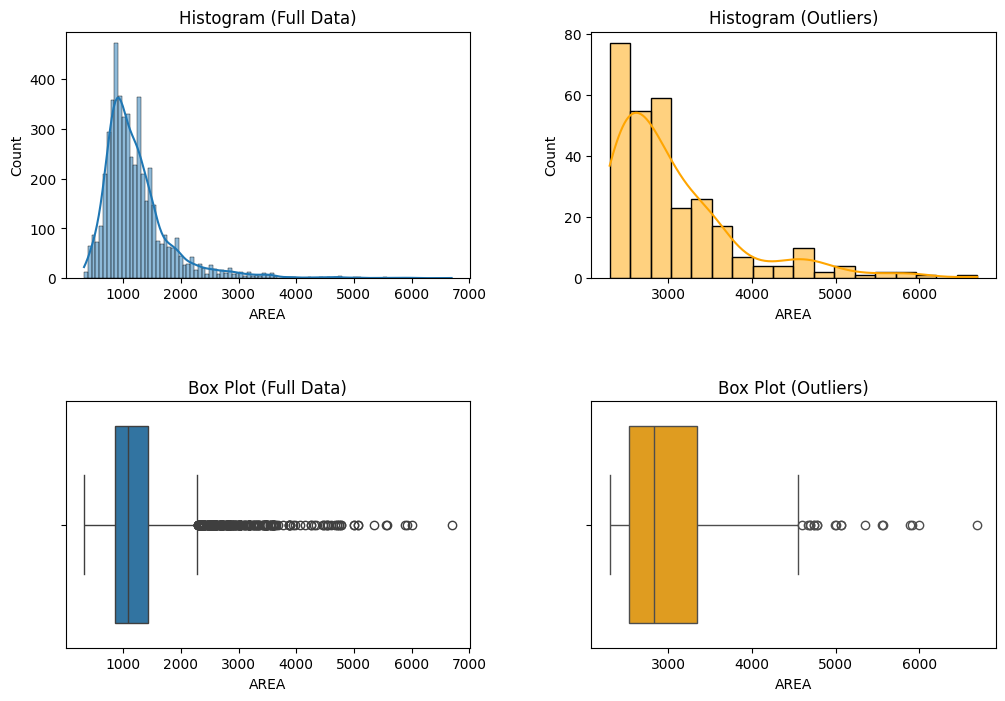


Outlier DataFrame for 'AREA':


,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,AGE,FACING,FURNISH,amenity_luxury,FLOOR_NUM,LATITUDE,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
1263,F71262812,flat,Rsh Signature,Kolkata South,Tollygunge,6.0,4.0,6694,12249.0,8.20,New Property,7,Fully furnished,338.0,21,22.500000,88.350000,RSH Signature,30.0,"['2 Metro Stations', '2 Religious Places', '1 ...","Best location , golf club road.. Good communic..."
4997,L71059668,flat,Ambuja Ujjwala The Condoville,Kolkata East,New Town,4.0,2.0,6000,6666.0,4.00,New Property,7,Fully furnished,314.0,11,22.600691,88.469454,Ambuja Ujjwala The Condoville,13.0,"['2 Religious Places', '3 ATMs', '5 Hospitals'...",Located in the popular residential address of ...
1875,B71216192,flat,Rsh Signature,Kolkata South,Tollygunge,4.0,3.0,5915,12679.0,7.50,Relatively New Property,7,Fully furnished,527.0,15,22.497815,88.350904,RSH Signature,30.0,"['2 Metro Stations', '3 Religious Places', '3 ...",Rsh signature brings you elegant homes in kolk...
3918,Q63106988,flat,Aqua Beaumont,Kolkata South,Em Bypass,5.0,2.0,5889,15282.0,9.00,Relatively New Property,0,Fully furnished,99.0,12,22.519222,88.399659,Aqua Beaumont,12.0,"['15 Religious Places', '3 ATMs', '12 Hospital...",This beautiful 5 bhk apartment/flat in em bypa...
4998,Q63312088,flat,Prasad Rare Earth,Kolkata North,Narkeldanga,4.0,3.0,5572,12562.0,7.00,Old Property,2,Fully furnished,579.0,26,22.573977,88.398249,Prasad Rare Earth,35.0,"['1 Metro Station', '1 Education', '1 ATM', '1...",This beautiful 8 bhk duplex apartment in narke...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076,F70586182,flat,Ps Panache,Kolkata North,Salt Lake,4.0,1.0,2300,11739.0,2.70,Relatively New Property,7,Fully furnished,590.0,10,22.570171,88.447571,PS Panache,25.0,"['1 Shopping', '2 Educations', '2 Hospitals', ...",Check out this 4 bhk apartment for sale in ps ...
1357,F71014262,flat,Ps One 10,Kolkata East,New Town,4.0,3.0,2300,11304.0,2.60,Old Property,8,Fully furnished,692.0,11,22.570637,88.461777,PS ONE 10,20.0,"['1 Metro Station', '1 Shopping', '2 Education...",This apartment is located on the 11th floor in...
4036,W70723576,flat,Radha Apartments,Kolkata South,Paddapukur,4.0,2.0,2300,8695.0,2.00,Old Property,0,Fully furnished,158.0,2,22.530240,88.348830,radha apartments,4.0,"['2 Metro Stations', '2 Religious Places', '3 ...",Centrally located in the bhawanipur-Paddapukur...
2122,N71139730,flat,NaN,Kolkata South,Alipore,3.0,1.0,2300,15217.0,3.50,Moderately Old,2,Luxury furnished,238.0,4,22.518732,88.326186,On Request,6.0,"['5 Religious Places', '5 ATMs', '23 Hospitals...",Looking for a 3 bhk property for sale in kolka...


In [155]:
column_details(df,'AREA',value_counts=False,all_column=True)

# BEDROOM_NUM

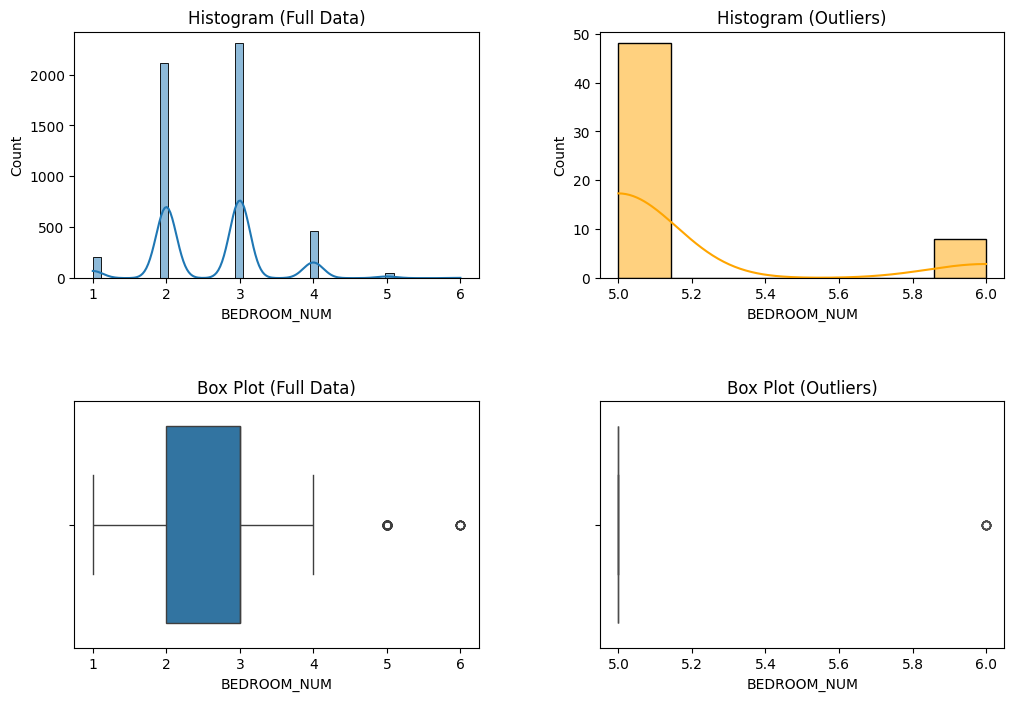


Outlier DataFrame for 'BEDROOM_NUM':


,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,...,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
1263,F71262812,flat,Rsh Signature,Kolkata South,Tollygunge,...,88.350000,RSH Signature,30.0,"['2 Metro Stations', '2 Religious Places', '1 ...","Best location , golf club road.. Good communic..."
2101,V71110692,flat,Ps Navyom,Kolkata South,New Alipore,...,88.331069,PS Navyom,11.0,"['2 Metro Stations', '4 Shoppings', '1 Connect...",A 6 bhk duplex in the premium tower at the 4th...
4830,A67641986,flat,Propterior,Kolkata South,Ballygunge Circular Road,...,88.357662,Propterior,12.0,"['1 Shopping', '1 Religious Place', '3 ATMs', ...","Situated in ballygunge circular road, kolkata ..."
4547,X68257476,flat,NaN,Kolkata East,New Town,...,88.450584,on request,4.0,"['1 Metro Station', '4 ATMs', '5 Hospitals', '...","A 6 bhk flat in new town, kolkata east is avai..."
3893,D71124348,flat,S.K Real Estate,Kolkata South,New Alipore,...,88.325146,S.K Real Estate,4.0,"['1 Shopping', '5 Religious Places', '5 ATMs',...",Located in the popular residential address of ...
...,...,...,...,...,...,...,...,...,...,...,...
763,I71394786,flat,Rajwada Royal Gardens,Kolkata South,Narendrapur,...,88.401162,Rajwada Royal Gardens,20.0,"['1 Metro Station', '2 Shoppings', '2 Educatio...","Book your 5 BHK flat in Narendrapur, Kolkata S..."
5003,L53259672,flat,Z Projects,Kolkata South,Em Bypass,...,88.354690,Z Projects,38.0,"['2 Metro Stations', '1 Shopping', '1 Religiou...","A beautiful 5 bhk apartment in em bypass, kolk..."
274,L71261538,flat,Swarnamani,Kolkata North,Em Bypass,...,88.399053,Swarnamani,32.0,"['1 Hospital', '1 Airport', '1 Bus Stop', '1 R...",Raw flat on 23rd floor with 2 car parkings. No...
854,E70965944,flat,Tata Avenida,Kolkata East,New Town,...,88.496134,Tata Avenida,29.0,"['2 Shoppings', '5 Educations', '2 Hospitals',...",Make Tata Avenida your next home. Book your 5 ...


In [156]:
column_details(df,'BEDROOM_NUM')

In [157]:
x = df[df['Price_per_sqft']<=20000]
(x['AREA']/x['BEDROOM_NUM']).quantile(0.2)

370.0

In [158]:

df[df['AREA']/df['BEDROOM_NUM']<370][['BEDROOM_NUM','AREA','Price_per_sqft','PRICE','TOTAL_FLOOR']].sort_values(by='AREA', ascending=False)


,BEDROOM_NUM,AREA,Price_per_sqft,PRICE,TOTAL_FLOOR
944,5.0,1800,3666.0,0.66,3.0
3790,5.0,1750,4857.0,0.85,4.0
633,5.0,1748,5720.0,1.00,5.0
3549,5.0,1600,5625.0,0.90,4.0
4078,5.0,1550,3548.0,0.55,4.0
...,...,...,...,...,...
1003,1.0,325,6769.0,0.22,4.0
588,1.0,320,3900.0,0.16,5.0
785,1.0,320,5555.0,0.12,4.0
3245,1.0,320,6875.0,0.22,4.0


In [159]:
df[df['AREA'] / df['BEDROOM_NUM'] < 370].groupby('BEDROOM_NUM')['AREA'].min().reset_index()


,BEDROOM_NUM,AREA
0,1.0,320
1,2.0,445
2,3.0,644
3,4.0,1009
4,5.0,881


No problem whith AREA vs BHK ratio.
because
- 1BHK AREA minimum value should be greater than 250 sqft.
- 2BHK AREA minimum value should be greater than 390 sqft.
- 3BHK AREA minimum value should be greater than 468 sqft.
- 4BHK AREA minimum value should be greater than 700 sqft.
- 5BHK AREA minimum value should be greater than 800 sqft.
  - (Domain standard)

In [160]:
df[df['BEDROOM_NUM']==5].sort_values(by='AREA')


,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,...,FACING,FURNISH,amenity_luxury,FLOOR_NUM,LATITUDE,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
3798,R71082752,flat,NaN,Kolkata North,Airport,5.0,1.0,881,3499.0,0.31,...,0,Fully furnished,NaN,1,22.643876,88.425956,on request,4.0,"['3 Religious Places', '3 ATMs', '23 Hospitals...",This project is located at nearby airport 1no ...
143,C70775190,flat,K.N.C Road Nayan Kanan,Kolkata North,Barasat,5.0,1.0,1302,6818.0,0.75,...,8,Fully furnished,512.0,2,22.591251,88.383982,K.N.C Road Nayan Kanan,2.0,"['4 ATMs', '20 Hospitals', '3 Attractions', '1...",The property is located in a prime location of...
4078,S71312846,flat,NaN,Kolkata South,Garia,5.0,1.0,1550,3548.0,0.55,...,2,Luxury furnished,21.0,2,22.457578,88.383237,On Request,4.0,"['2 Metro Stations', '9 Religious Places', '2 ...","Situated in garia, kolkata south, on request i..."
3549,G71081690,flat,NaN,Kolkata South,New Garia,5.0,2.0,1600,5625.0,0.90,...,7,Fully furnished,87.0,2,22.478528,88.404541,on request,4.0,"['2 Metro Stations', '7 Religious Places', '3 ...",Very close to kavi subhas metro station and e ...
633,R70310506,flat,Sagardeep Apartment,Kolkata North,Teghoria,5.0,2.0,1748,5720.0,1.00,...,0,Semi-furnished,NaN,3,22.620032,88.431792,Sagardeep Apartment,5.0,"['2 Religious Places', '7 ATMs', '24 Hospitals...",Fully furnished flat with \nBig modular kitche...
3790,I70515728,flat,Apartments,Kolkata South,Parnasree Palli,5.0,1.0,1750,4857.0,0.85,...,0,Fully furnished,103.0,1,22.509326,88.301471,apartments,4.0,"['1 Shopping', '6 Religious Places', '2 ATMs',...","This 5 bhk flat is located in apartments, whic..."
944,L71268540,flat,Standalone Building,Kolkata South,Thakurpukur Bazar,5.0,2.0,1800,3666.0,0.66,...,5,Fully furnished,284.0,2,22.463760,88.307180,Standalone Building,3.0,"['2 Religious Places', '12 Hospitals']",Standalone building is one of the most popular...
387,E68663770,flat,Sk Tower Rabindrapalli,Kolkata North,Kestopur,5.0,3.0,2250,3555.0,0.80,...,0,Semi-furnished,103.0,5,22.597569,88.433155,Sk Tower Rabindrapalli,5.0,"['3 Metro Stations', '1 Religious Place', '6 A...",This building is on main road towards new salt...
1402,N69974044,flat,NaN,Kolkata South,Santoshpur,5.0,1.0,2300,7608.0,1.75,...,2,Fully furnished,194.0,1,22.472937,88.377266,On Request,4.0,"['2 Metro Stations', '7 Religious Places', '3 ...","This 5bhk flat is located in on request, which..."
162,M69847444,flat,Swarnabhoomi,Kolkata West,Santragachi,5.0,2.0,2520,3115.0,0.78,...,0,Luxury furnished,39.0,2,22.581763,88.274735,Swarnabhoomi,6.0,"['11 Religious Places', '10 Hospitals', '1 Bus...",Room size bigger than normal flat\nShiv mandir...


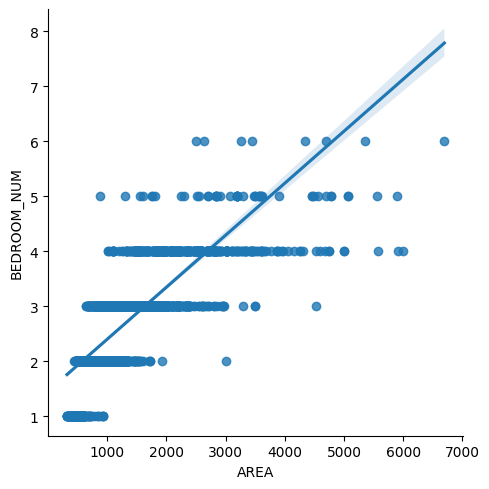

In [161]:
sns.lmplot(df,x = 'AREA', y = 'BEDROOM_NUM')

In [162]:
df.columns

Index(['PROP_ID', 'PROPERTY_TYPE', 'SOCIETY_NAME', 'CITY', 'location',
       'BEDROOM_NUM', 'BALCONY_NUM', 'AREA', 'Price_per_sqft', 'PRICE', 'AGE',
       'FACING', 'FURNISH', 'amenity_luxury', 'FLOOR_NUM', 'LATITUDE',
       'LONGITUDE', 'PROP_NAME', 'TOTAL_FLOOR', 'FORMATTED_LANDMARK_DETAILS',
       'DESCRIPTION'],
      dtype='object')

# BALCONY_NUM:

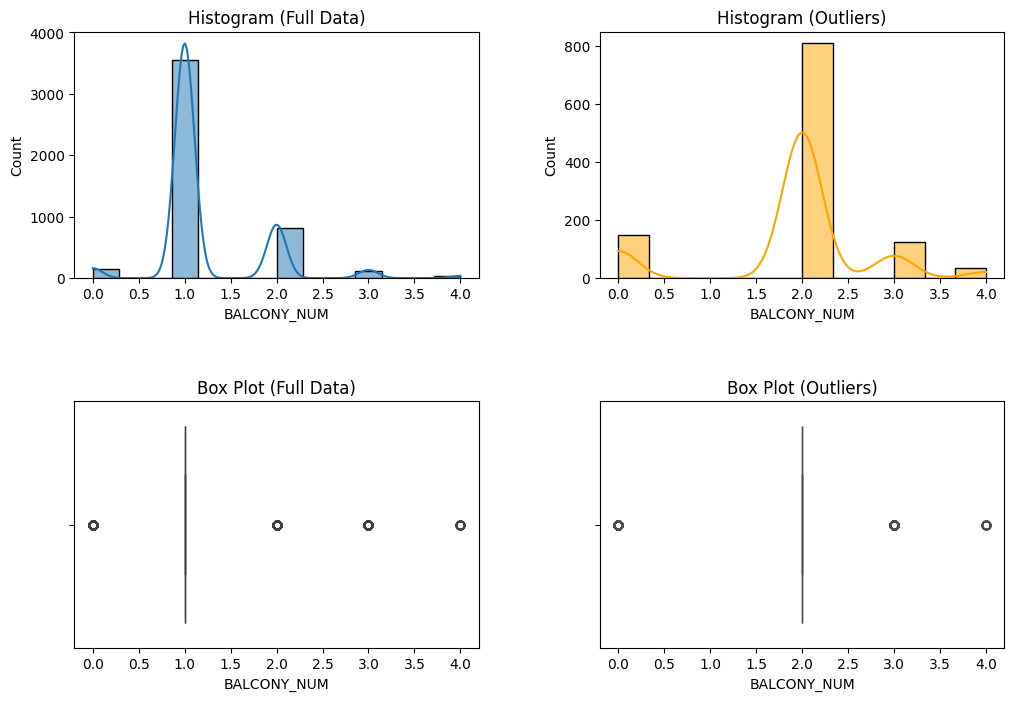


Outlier DataFrame for 'BALCONY_NUM':


,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,AGE,FACING,FURNISH,amenity_luxury,FLOOR_NUM,LATITUDE,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
4212,L70997898,flat,Nbcc Vibgyor Towers,Kolkata East,New Town,5.0,4.0,3079,4904.0,1.51,Relatively New Property,5,Luxury furnished,173.0,14,22.576903,88.454165,NBCC Vibgyor Towers,15.0,"['2 Metro Stations', '1 Religious Place', '4 A...","This beautiful 5 bhk flat in new town, kolkata..."
2126,Z71103212,flat,The X-One,Kolkata East,New Town,4.0,4.0,1930,7668.0,1.48,Old Property,7,Fully furnished,948.0,26,22.600691,88.469454,The X-One,30.0,"['2 Religious Places', '3 ATMs', '5 Hospitals'...",The x-One is one of kolkata east's most sought...
4411,R70773812,flat,Tata Avenida,Kolkata East,New Town,4.0,4.0,3114,10276.0,3.20,Relatively New Property,7,Fully furnished,896.0,18,22.581179,88.496134,Tata Avenida,29.0,"['2 Shoppings', '5 Educations', '2 Hospitals',...","This beautiful 4 bhk flat in new town, kolkata..."
4412,V70773676,flat,Tata Avenida,Kolkata East,New Town,4.0,4.0,3245,10785.0,3.50,Relatively New Property,7,Semi-furnished,1007.0,28,22.581179,88.496134,Tata Avenida,29.0,"['2 Shoppings', '5 Educations', '2 Hospitals',...",This lovely 4 bhk apartment/flat in new town i...
119,H70803036,flat,Ps Jiva,Kolkata East,Chingrighata,3.0,4.0,1116,17204.0,1.92,Old Property,7,Fully furnished,338.0,11,22.556650,88.411680,PS Jiva,12.0,"['1 Metro Station', '1 Shopping', '1 Connectiv...",11th floor exclusive unit...With all room havi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,X69806304,flat,Tandem Apartment,Kolkata South,Ballygunge Circular Road,2.0,0.0,1000,7500.0,0.75,New Property,0,Fully furnished,85.0,1,22.536398,88.357662,TANDEM APARTMENT,4.0,"['1 Shopping', '1 Religious Place', '3 ATMs', ...",Flat at good locality and well maintained.\n1....
785,R68989260,flat,Green Huts 1,Kolkata South,Bagha Jatin,1.0,0.0,320,5555.0,0.12,Moderately Old,3,Luxury furnished,483.0,0,22.483692,88.381771,Green Huts 1,4.0,"['9 Religious Places', '2 ATMs', '13 Hospitals...",The flat is well maintained. Rooms were refurb...
2539,W70896346,flat,Tirupati Green Residency,Kolkata North,Baguiati,1.0,0.0,584,3500.0,0.20,Old Property,3,Fully furnished,177.0,1,22.616040,88.430169,Tirupati Green Residency,5.0,"['1 Religious Place', '7 ATMs', '22 Hospitals'...","Very good location,on hatiara main road.7 mins..."
4976,A69831594,flat,Standalone,Kolkata South,Southend Park,3.0,0.0,1800,5833.0,1.05,Moderately Old,4,Luxury furnished,208.0,0,22.512308,88.366936,Standalone,3.0,"['2 Religious Places', '18 Hospitals', '1 Attr...",Check out this 3 bhk apartment for sale in sta...


In [163]:
column_details(df,'BALCONY_NUM',all_column=True)

# amenity_luxury:

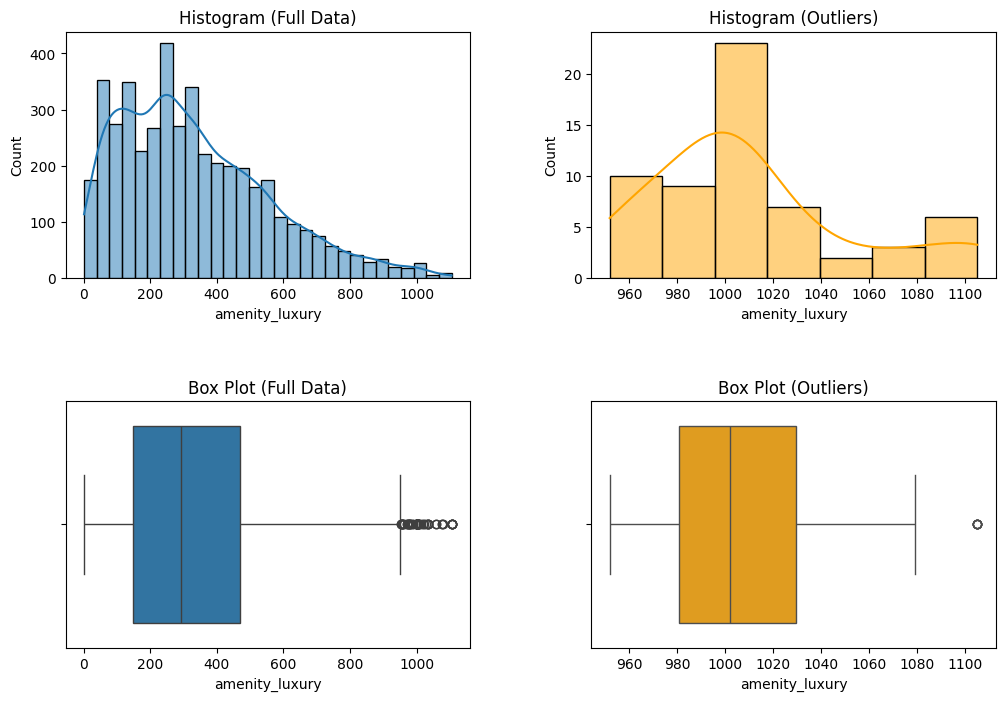


Outlier DataFrame for 'amenity_luxury':


,PROP_ID,PROPERTY_TYPE,SOCIETY_NAME,CITY,location,BEDROOM_NUM,BALCONY_NUM,AREA,Price_per_sqft,PRICE,AGE,FACING,FURNISH,amenity_luxury,FLOOR_NUM,LATITUDE,LONGITUDE,PROP_NAME,TOTAL_FLOOR,FORMATTED_LANDMARK_DETAILS,DESCRIPTION
1976,G65893020,flat,Diamond City South,Kolkata South,Tollygunge,3.0,1.0,1435,7247.0,1.04,New Property,2,Fully furnished,1105.0,7,22.500000,88.350000,Diamond City South,20.0,"['2 Metro Stations', '2 Religious Places', '1 ...",3 bhk multistory apartment for sale in tollygu...
1977,I65892362,flat,Diamond City South,Kolkata South,Tollygunge,2.0,1.0,1187,7245.0,0.86,New Property,7,Fully furnished,1105.0,12,22.500000,88.350000,Diamond City South,20.0,"['2 Metro Stations', '2 Religious Places', '1 ...",2 bhk multistory apartment for sale in tollygu...
1967,I64291924,flat,Merlin The One,Kolkata South,Tollygunge,3.0,1.0,1400,9071.0,1.27,Old Property,2,Fully furnished,1105.0,12,22.489445,88.337073,Merlin The One,17.0,"['1 Metro Station', '1 Shopping', '1 Connectiv...",3 bhk flat for sale in tollygunge kolkata sout...
2127,B71102080,flat,The Venue,Kolkata East,New Town,2.0,1.0,770,8441.0,0.65,Old Property,7,Fully furnished,1105.0,25,22.600691,88.469454,The Venue,30.0,"['2 Religious Places', '3 ATMs', '5 Hospitals'...","This beautiful 2 bhk flat in new town, kolkata..."
1965,S64225404,flat,Diamond City South,Kolkata South,Tollygunge,3.0,1.0,1737,7714.0,1.34,Relatively New Property,7,Fully furnished,1105.0,15,22.500000,88.350000,Diamond City South,20.0,"['2 Metro Stations', '2 Religious Places', '1 ...",3 bhk flat for sale in tollygunge kolkata sout...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,H70489516,flat,Dlf New Town Heights,Kolkata East,New Town,3.0,2.0,2113,5915.0,1.25,Relatively New Property,5,Fully furnished,957.0,12,22.600691,88.469454,DLF New Town Heights,33.0,"['2 Religious Places', '3 ATMs', '5 Hospitals'...",Looking for a 3 bhk property for sale in kolka...
4052,E61745982,flat,Ideal Aquaview,Kolkata East,New Town,3.0,1.0,1475,6101.0,0.90,Relatively New Property,5,Fully furnished,956.0,15,22.571168,88.448828,Ideal AquaView,25.0,"['3 Shoppings', '3 Educations', '1 Hospital', ...","Ideal aquaview in new town, kolkata east by id..."
776,A71102182,flat,The Venue,Kolkata East,New Town,2.0,1.0,770,8311.0,0.64,Old Property,7,Fully furnished,956.0,26,22.600691,88.469454,The Venue,30.0,"['2 Religious Places', '3 ATMs', '5 Hospitals'...",The venue is one of kolkata east's most sought...
1593,S71189732,flat,Alcove New Kolkata Prayag,Kolkata West,Serampore,3.0,1.0,1040,6730.0,0.70,Old Property,7,Semi-furnished,954.0,10,22.737306,88.351315,Alcove New Kolkata Prayag,24.0,"['1 Metro Station', '1 Airport', '1 Miscellane...",Located in the popular residential address of ...


In [164]:
column_details(df,'amenity_luxury',value_counts= False,all_column=True)

<Axes: xlabel='amenity_luxury', ylabel='PRICE'>

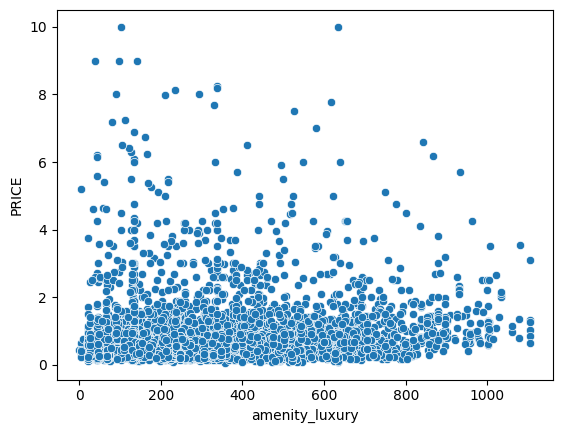

In [165]:
sns.scatterplot(df, x = 'amenity_luxury', y = 'PRICE')

In [166]:
df.columns

Index(['PROP_ID', 'PROPERTY_TYPE', 'SOCIETY_NAME', 'CITY', 'location',
       'BEDROOM_NUM', 'BALCONY_NUM', 'AREA', 'Price_per_sqft', 'PRICE', 'AGE',
       'FACING', 'FURNISH', 'amenity_luxury', 'FLOOR_NUM', 'LATITUDE',
       'LONGITUDE', 'PROP_NAME', 'TOTAL_FLOOR', 'FORMATTED_LANDMARK_DETAILS',
       'DESCRIPTION'],
      dtype='object')

In [167]:
#df.to_csv('outlier_treated.csv', index=False)